In [1]:
from ase.build import make_supercell
from ase.calculators.eam import EAM
from ase.calculators.lammpsrun import LAMMPS
from ase.io import read

import catkit
from catkit import Gratoms
from catkit.gen.adsorption import get_adsorption_sites

from mcmc import mcmc_run, slab_energy, get_adsorption_coords
import os
import numpy as np

import sys
sys.path.append("/home/dux/")
from htvs.djangochem.pgmols.utils import surfaces

os.environ["PROJECT_DIR"] = os.getcwd()

In [2]:
# SiTiO3 from HTVS db
import sys
import os
import django
import numpy as np
from tqdm import tqdm
import pandas as pd
import pickle as pkl
sys.path.append('/home/dux/htvs/')
sys.path.append('/home/dux/htvs/djangochem/')

# from imports import *
# from django_imports import *
# from pymatgen.core.periodic_table import Element
# from chemconfigs.vasp.defaults import Magmom
# from ase.visualize import view

# setup the djhango settings file.  Change this to use the settings file that connects you to your desired database
os.environ["DJANGO_SETTINGS_MODULE"] = "djangochem.settings.orgel"
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"  # CAUTION!!! LINE NECESSARY WHEN INTERACTING WITH DATABASE IN JUPYTER NOTEBOOK. DO NOT USE THIS LINE IF YOU ARE PLANNING ON SAVING/REMOVING THINGS FROM THE DATABASE!!!!!

# this must be run to setup access to the django settings and make database access work etc.
django.setup()
# from jobs.models import Job, JobConfig
# from django.contrib.contenttypes.models import ContentType
# from ase.io import write

from pgmols.models import Surface
# from analysis.structure.perovskite import PerovskiteAnalyzer
# from pymatgen.core.periodic_table import Element

unit_slab = Surface.objects.get(id=203512369).as_ase_gratoms()

# get supercell
multiplier = np.diag([4, 4, 1])
slab = make_supercell(unit_slab, multiplier)

In [3]:
# manually get adsorption coords
coords, connectivity, sym_idx = get_adsorption_sites(slab, symmetry_reduced=False)

# get absolute adsorption coords
element = 'O'
ads = catkit.gratoms.Gratoms(element)

# ads_coords = get_adsorption_coords(slab, ads, connectivity)

/home/dux/miniconda3/envs/htvs/lib/python3.7/site-packages/catkit/gen/adsorption.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/miniconda3/envs/htvs/lib/python3.7/site-packages/catkit/gen/adsorption.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r2_topology = np.array(self.r2_topology)


In [4]:
slab = make_supercell(unit_slab, multiplier)
surface_name = "SiTiO3_001_4x4"

print("slab type", type(slab))
num_runs = 10
# no calc, testing to just get some states
history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=0, alpha=1, slab=slab, calc=None, testing=True, surface_name=surface_name, element=element)

slab type <class 'catkit.gratoms.Gratoms'>


/home/dux/miniconda3/envs/htvs/lib/python3.7/site-packages/catkit/gen/utils/coordinates.py:104: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(4 * d**2 * r[1]**2 - x0**2)
/home/dux/miniconda3/envs/htvs/lib/python3.7/site-packages/catkit/gen/utils/coordinates.py:122: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(r[0]**2 - x**2 - y**2)


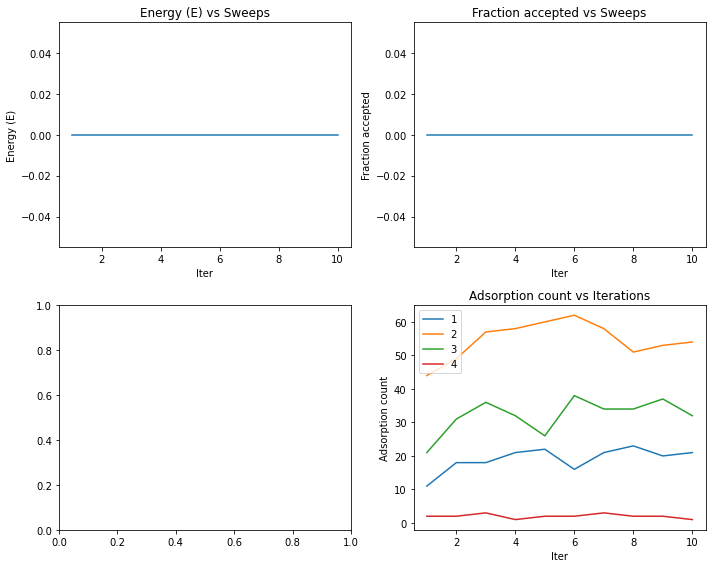

In [5]:
import matplotlib.pyplot as plt
runs = range(1, num_runs+1)

# do the plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(runs, energy_hist)
ax[0, 0].set_xlabel("Iter")
ax[0, 0].set_ylabel("Energy (E)")
ax[0, 0].set_title("Energy (E) vs Sweeps")

ax[0, 1].plot(runs, frac_accept_hist)
ax[0, 1].set_xlabel("Iter")
ax[0, 1].set_ylabel("Fraction accepted")
ax[0, 1].set_title("Fraction accepted vs Sweeps")

ax[1, 1].plot(runs, np.array(list(adsorption_count_hist.values())).T)
ax[1, 1].set_xlabel("Iter")
ax[1, 1].set_ylabel("Adsorption count")
ax[1, 1].legend(adsorption_count_hist.keys())
ax[1, 1].set_title("Adsorption count vs Iterations")

fig.show()
fig.tight_layout()